# 🧬 PROJE 3: NGS Veri Kalite Kontrolü (FASTQ Quality Control)

## Senaryo: Laboratuvardaki dizileme cihazından (Illumina) ham veriler çıktı. Ancak bu veriler bazen hatalı olabilir. Makine, DNA'nın sonlarına doğru yorulur ve hatalı okumalar yapar. Bizim görevimiz, bu verilerin kalitesini ölçmek ve "Bu veri analize uygun mu?" kararını vermek.

### Kullanılan Format: FASTQ (DNA harfleri + Kalite puanları).
### Kullanılan Metrik: Phred Quality Score (Q-Score).

### - Blok 1: Sentetik FASTQ Verisi Üretme
### - Burada Illumina cihazının tipik hatasını simüle ediyoruz: Okuma uzadıkça kalite düşer.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import random
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO

# --- 1. VERİ SİMÜLASYONU: Sanal Illumina Okumaları ---
# Gerçek hayatta bu dosya cihazdan gelir. Biz simüle ediyoruz.

def generate_synthetic_fastq(filename, num_reads=5000, read_len=100):
    records = []
    dna_bases = "ACGT"
    
    print(f"🧬 {num_reads} adet sentetik okuma üretiliyor (Uzunluk: {read_len}bp)...")
    
    for i in range(num_reads):
        # Rastgele DNA dizisi oluştur
        sequence = "".join(random.choice(dna_bases) for _ in range(read_len))
        
        # Kalite Skorları (Phred Score) Oluşturma
        # Simülasyon: Başlangıçta kalite yüksek (30-40), sonlara doğru düşüyor (10-30).
        # Bu, gerçek dizileme cihazlarının tipik davranışıdır.
        quality_scores = []
        for pos in range(read_len):
            if pos < 50:
                q = random.randint(30, 40) # İlk 50 baz çok kaliteli
            else:
                q = random.randint(15, 35) # Sonlara doğru kalite düşüyor
            quality_scores.append(q)
            
        # Biopython Kaydı Oluştur
        record = SeqRecord(
            Seq(sequence),
            id=f"SEQ_{i+1}",
            description="Synthetic Illumina Read",
            letter_annotations={"phred_quality": quality_scores}
        )
        records.append(record)

    # FASTQ dosyası olarak kaydet
    SeqIO.write(records, filename, "fastq")
    print(f"✅ '{filename}' dosyası başarıyla oluşturuldu.")

# Fonksiyonu çalıştır
fastq_file = "synthetic_data.fastq"
generate_synthetic_fastq(fastq_file)

🧬 5000 adet sentetik okuma üretiliyor (Uzunluk: 100bp)...
✅ 'synthetic_data.fastq' dosyası başarıyla oluşturuldu.


In [5]:
# --- 2. ANALİZ: Pozisyon Bazlı Kalite Kontrolü ---

def analyze_fastq_quality(filename):
    quality_per_position = {} # Pozisyon bazında kalite skorlarını saklamak için bir sözlük

    #Biopython ile dosya okuma
    for record in SeqIO.parse(filename, "fastq"):
        phred_scores = record.letter_annotations["phred_quality"] # Kalite skorlarını al

        for pos, score in enumerate(phred_scores):
            if pos not in quality_per_position:
                quality_per_position[pos] = []
            quality_per_position[pos].append(score) # Pozisyona göre kalite skorlarını ekle

    # veriyi pandas datafreame'e dönüştür
    data = []
    for pos, scores in quality_per_position.items():
        for score in scores:
            data.append({"Position": pos, "Quality_Score": score})

    return pd.DataFrame(data)

print("🔍 FASTQ dosyası analiz ediliyor...")
df_quality = analyze_fastq_quality(fastq_file)
print("✅ Analiz tamamlandı. Tablo önizlemesi:")
print(df_quality.head())

🔍 FASTQ dosyası analiz ediliyor...
✅ Analiz tamamlandı. Tablo önizlemesi:
   Position  Quality_Score
0         0             30
1         0             38
2         0             39
3         0             36
4         0             32


### - Görselleştirme (FastQC Tarzı Rapor)
### -"Boxplot" kullanarak kalitenin düşüşünü göstereceğiz.

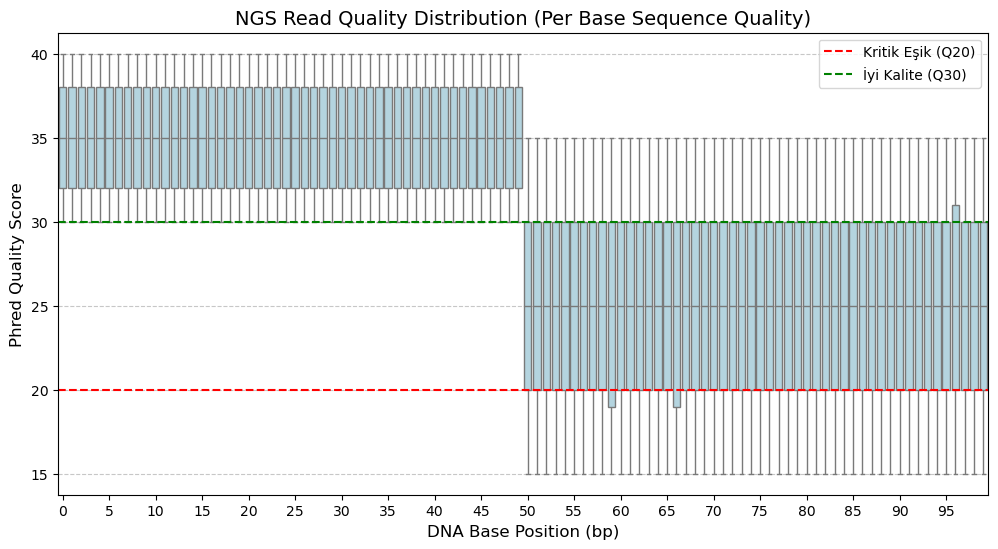


📊 GRAFİK YORUMU:
1. Yüksek Puanlar (30+): Yeşil çizginin üstü. Okumaların başı genelde buradadır.
2. Düşük Puanlar (<20): Kırmızı çizginin altı. Okumaların sonuna doğru kutuların aşağı kaydığını görebiliriz.
3. Karar: Eğer çok fazla kutu kırmızının altına iniyorsa, 'Trimming' (Kırpma) işlemi yapılmalıdır.



In [7]:
# --- 3. GÖRSELLEŞTİRME: Kalite Dağılım Grafiği ---

plt.figure(figsize=(12, 6))

# Boxplot: Her pozisyondaki kalite dağılımını gösterir
sns.boxplot(x="Position", y="Quality_Score", data=df_quality, showfliers=False, color="lightblue")

# Kritik Eşik Çizgisi (Q20 = %99 Doğruluk, Q30 = %99.9 Doğruluk)
plt.axhline(y=20, color='red', linestyle='--', label='Kritik Eşik (Q20)')
plt.axhline(y=30, color='green', linestyle='--', label='İyi Kalite (Q30)')

# Grafik Ayarları
plt.title("NGS Read Quality Distribution (Per Base Sequence Quality)", fontsize=14)
plt.xlabel("DNA Base Position (bp)", fontsize=12)
plt.ylabel("Phred Quality Score", fontsize=12)
plt.xticks(ticks=range(0, 100, 5), labels=range(0, 100, 5)) # X eksenini sadeleştir
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

print("""
📊 GRAFİK YORUMU:
1. Yüksek Puanlar (30+): Yeşil çizginin üstü. Okumaların başı genelde buradadır.
2. Düşük Puanlar (<20): Kırmızı çizginin altı. Okumaların sonuna doğru kutuların aşağı kaydığını görebiliriz.
3. Karar: Eğer çok fazla kutu kırmızının altına iniyorsa, 'Trimming' (Kırpma) işlemi yapılmalıdır.
""")